In [1]:
import control as ct
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

plt.style.use('../maroon_ipynb.mplstyle')

From lecture 15 notes, we are finding the frequency response for 

$$6\ddot{x}+12\dot{x}+174x=15f(t)$$

# Getting the Transfer Function

In [2]:
t, s = sp.symbols('t s')
x, f = sp.Function('x')(t), sp.Function('f')(t)

eq = sp.Eq(6*x.diff(t, 2) + 12*x.diff() + 174*x, 15*f)
eq

Eq(174*x(t) + 12*Derivative(x(t), t) + 6*Derivative(x(t), (t, 2)), 15*f(t))

In [3]:
lp = lambda expr: sp.laplace_transform(expr, t, s)[0]

eq_s = sp.Eq(lp(eq.lhs), lp(eq.rhs))
eq_s = eq_s.subs([
    (x.subs(t, 0), 0),
    (x.diff().subs(t, 0), 0)
])

eq_s

Eq(6*s**2*LaplaceTransform(x(t), t, s) + 12*s*LaplaceTransform(x(t), t, s) + 174*LaplaceTransform(x(t), t, s), 15*LaplaceTransform(f(t), t, s))

In [4]:
T_s = sp.solve(eq_s, lp(x))[0]/lp(f)
T_s.expand()

5/(2*s**2 + 4*s + 58)

In [5]:
T = ct.tf(5, [2, 4, 58])
T

TransferFunction(array([5]), array([ 2,  4, 58]))

# Getting the Magnitude and Phase Plots

In [6]:
# Find T(j*omega)
omega = sp.Symbol(r'\omega')
T_jw = T_s.subs(s, sp.I*omega)
T_jw

5/(2*(-\omega**2 + 2*I*\omega + 29))

In [7]:
# Find the magnitude
mag = sp.Abs(T_jw)
mag

5/Abs(-2*\omega**2 + 4*I*\omega + 58)

In [8]:
# Find the angle
ang = sp.arg(T_jw)  # arg = angle function in sympy
ang

arg(1/(-\omega**2 + 2*I*\omega + 29))

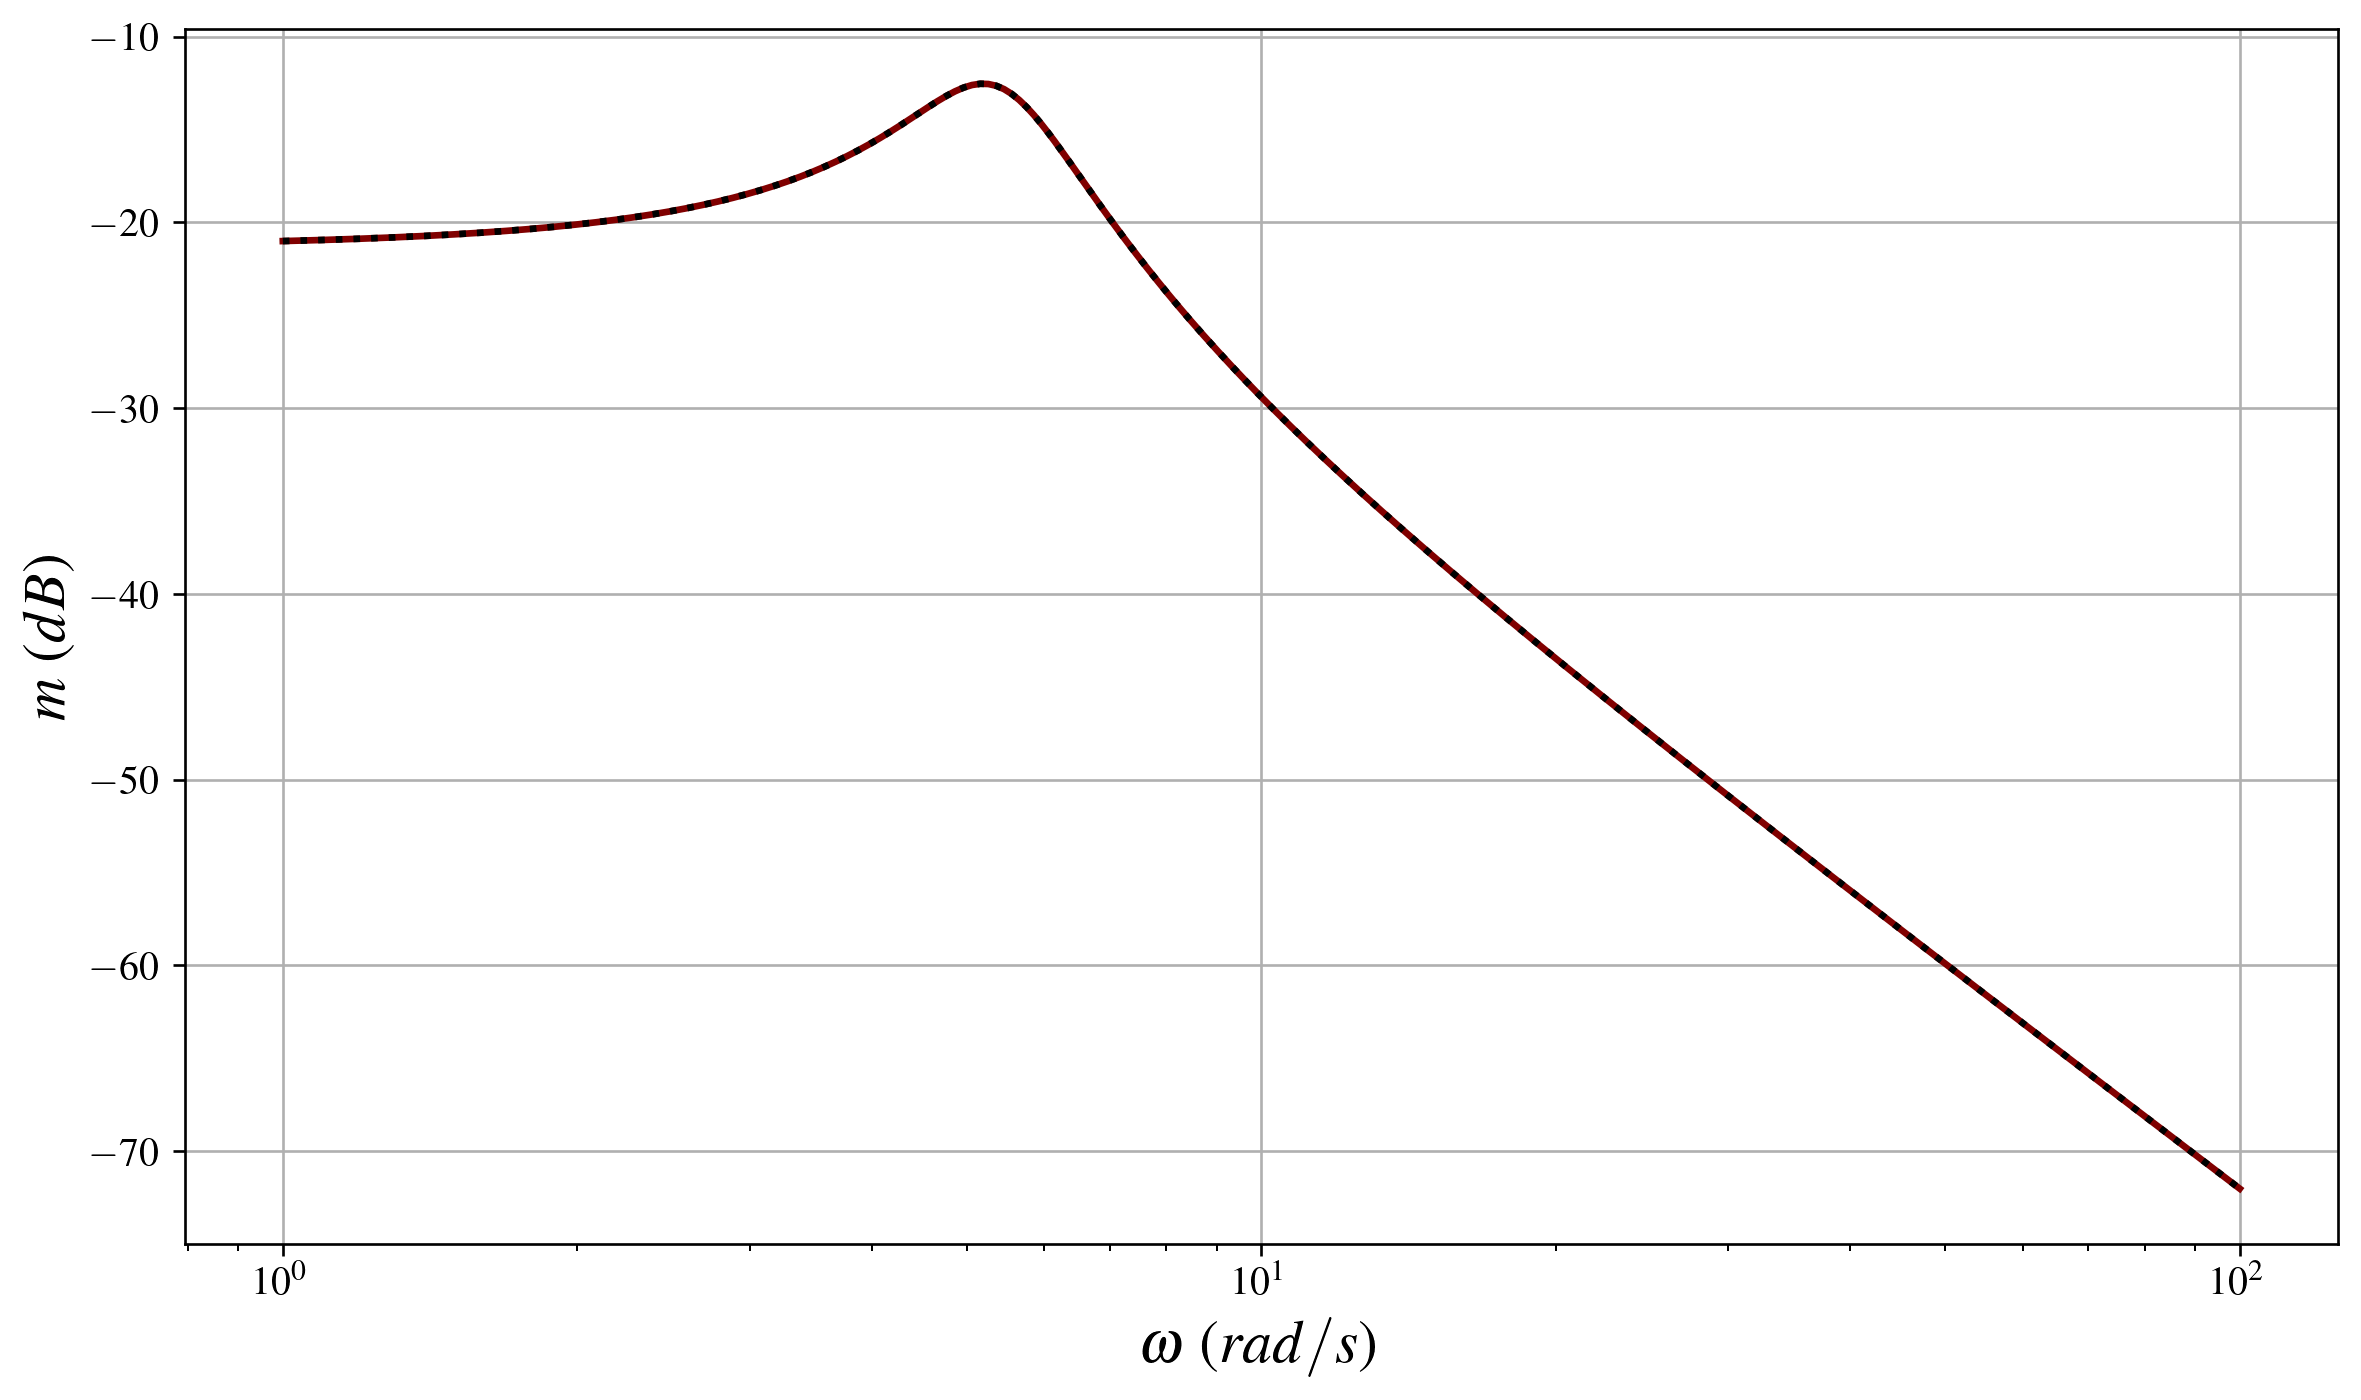

In [9]:
# Plotting the magnitude response
mag_lamb = sp.lambdify(omega, mag, modules='numpy')

# Checking the by hand solution
mag_hand = lambda om: 15/np.sqrt((174 - 6*om**2)**2 + 144*om**2)

omegas = np.linspace(1, 100, 1000)

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.plot(omegas, 20*np.log10(mag_lamb(omegas)))
ax.plot(omegas, 20*np.log10(mag_hand(omegas)), ls=':')
ax.set_xlabel(r'$\omega$ ($rad/s$)')
ax.set_ylabel(r'$m$ ($dB$)')
plt.show()

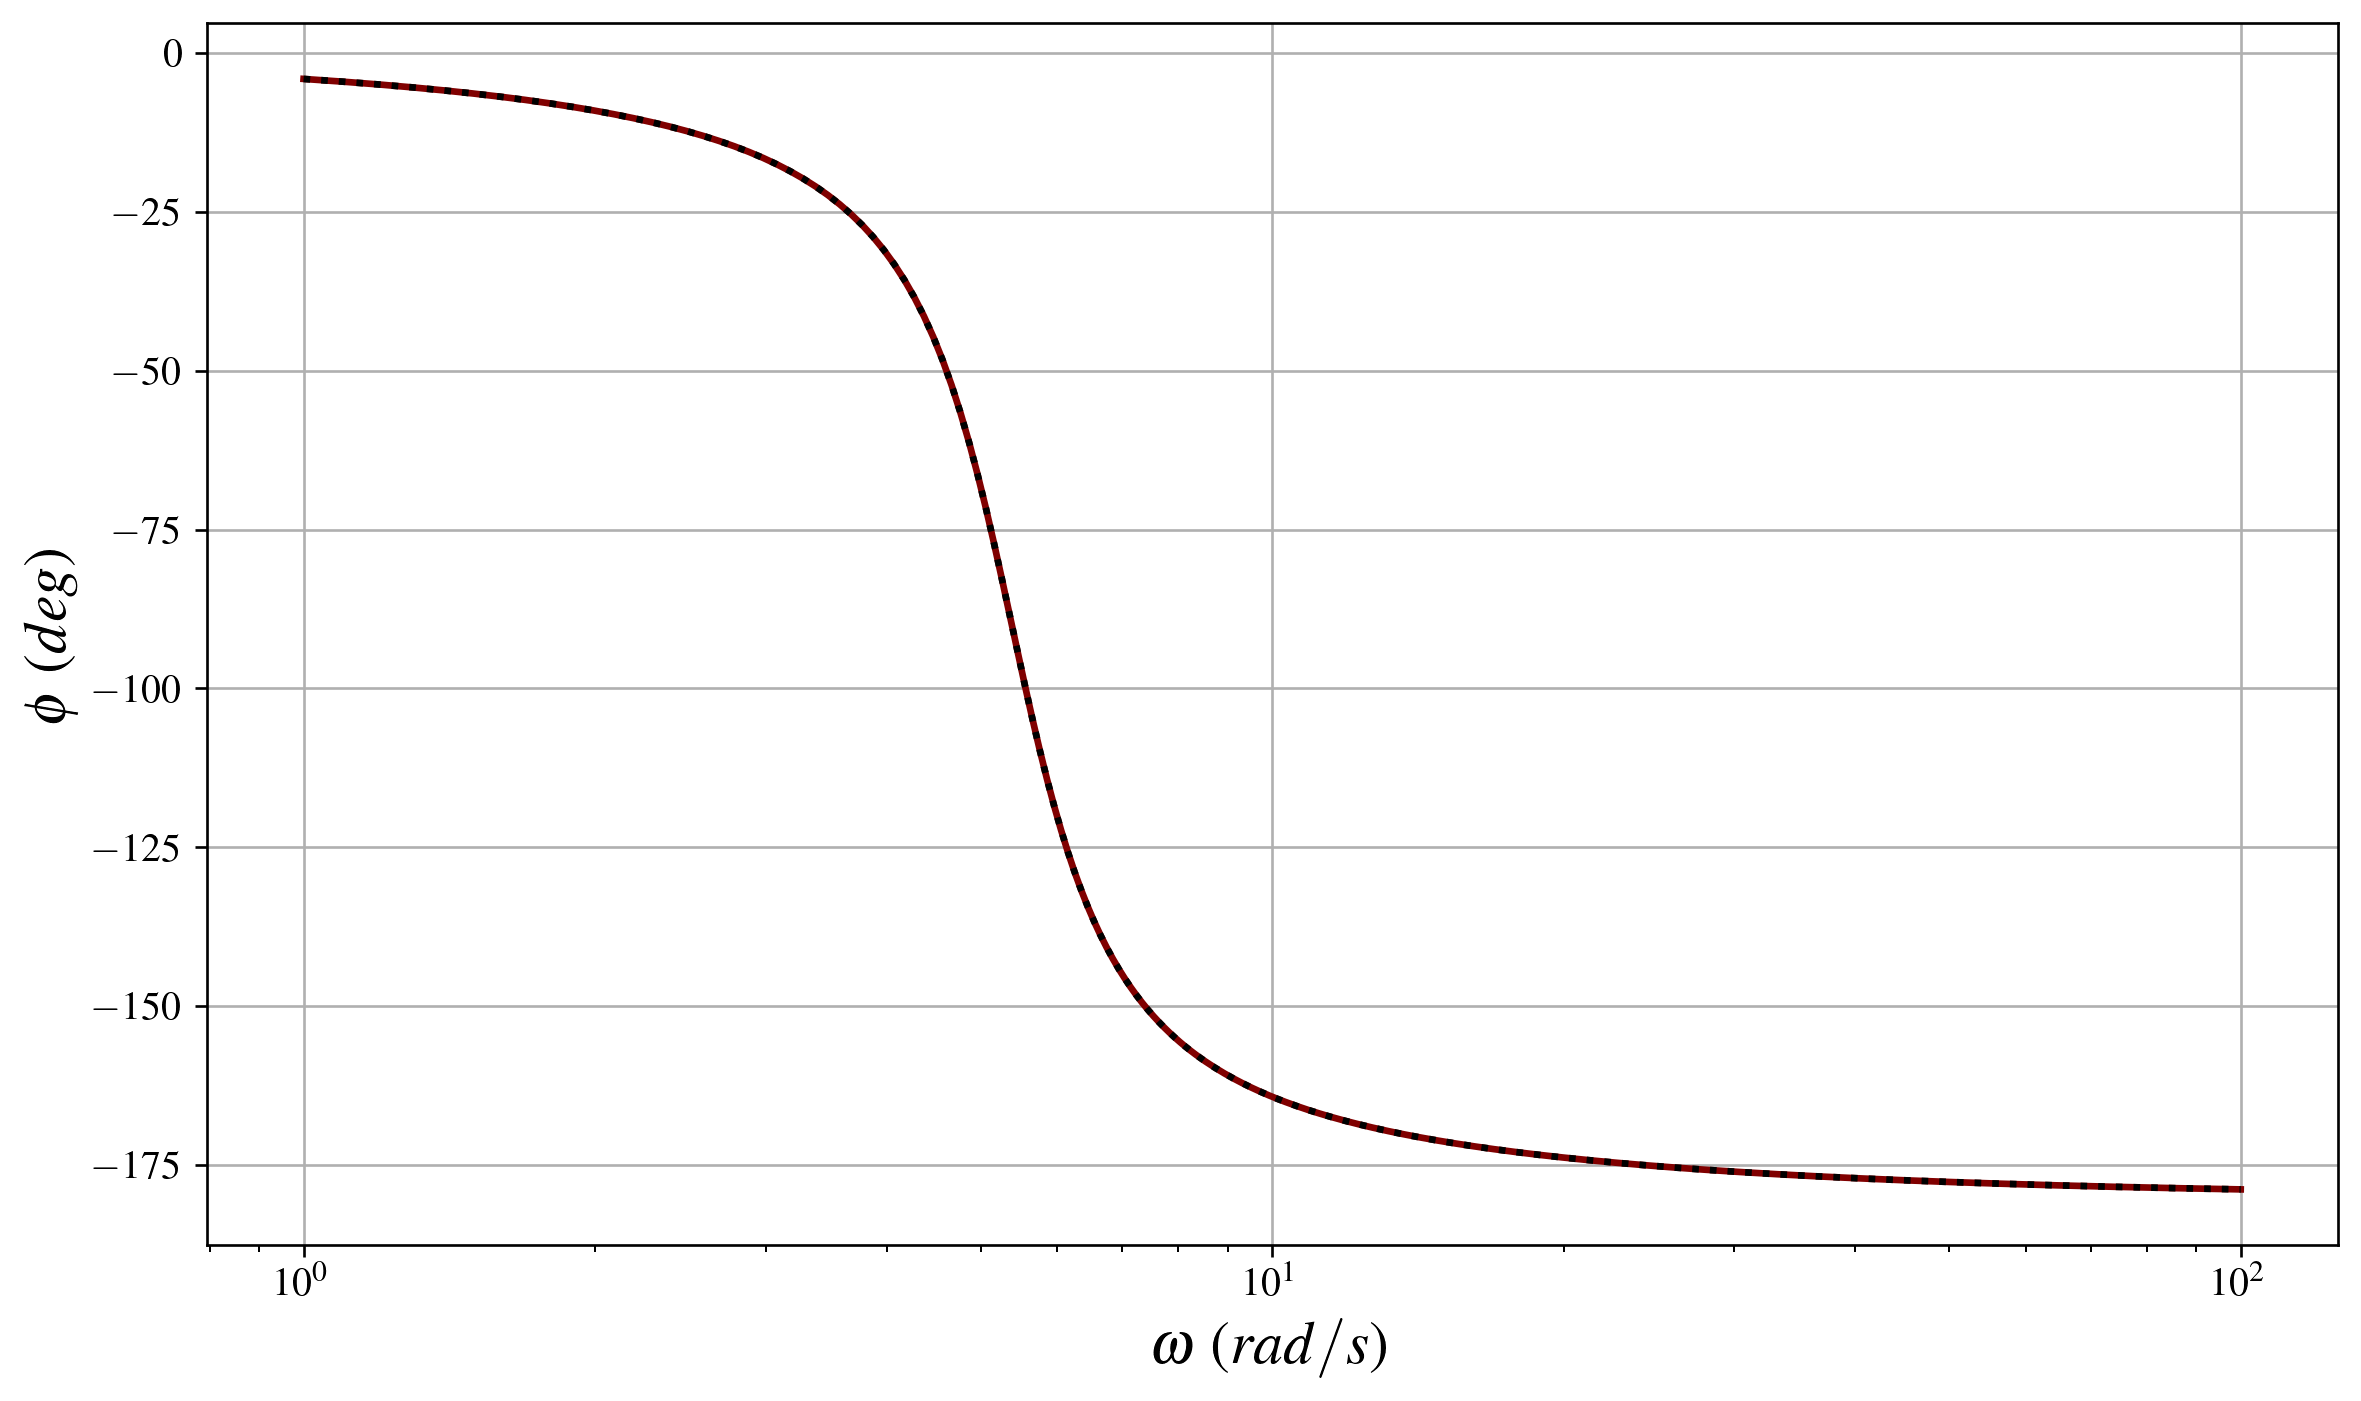

In [10]:
# Plotting the phase response
ang_lamb = sp.lambdify(omega, ang, modules='numpy')

# Checking the hand solution
# Method 1: Use np.arctan2()
ang_hand = -np.arctan2(12*omegas, 174 - 6*omegas**2)

# Method 2: Use np.piecewise
# ang_hand = np.piecewise(omegas,
#                         [174 - 6*omegas**2 > 0, 
#                          174 - 6*omegas**2 < 0],
#                         [lambda om: -np.arctan(12*om/(174 - 6*om**2)),
#                          lambda om: -np.arctan(12*om/(174 - 6*om**2)) - np.pi])

# Method 3: Make your own function
# def ang_hand(om):
#     if 174 - 6*om**2 > 0:
#         return -np.arctan(12*om/(174 - 6*om**2))
#     else:
#         return -np.arctan(12*om/(174 - 6*om**2)) - np.pi

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.plot(omegas, np.rad2deg(ang_lamb(omegas)))
ax.plot(omegas, np.rad2deg(ang_hand), ls=':')
# ax.plot(omegas, np.rad2deg(list(map(ang_hand, omegas))), ls=':')  # If using method 3
ax.set_xlabel(r'$\omega$ ($rad/s$)')
ax.set_ylabel(r'$\phi$ ($deg$)')
plt.show()

## Control Package Function
You can also obtain the magnitude and phase responses by using the `bode_plot` ( or `bode`) function.

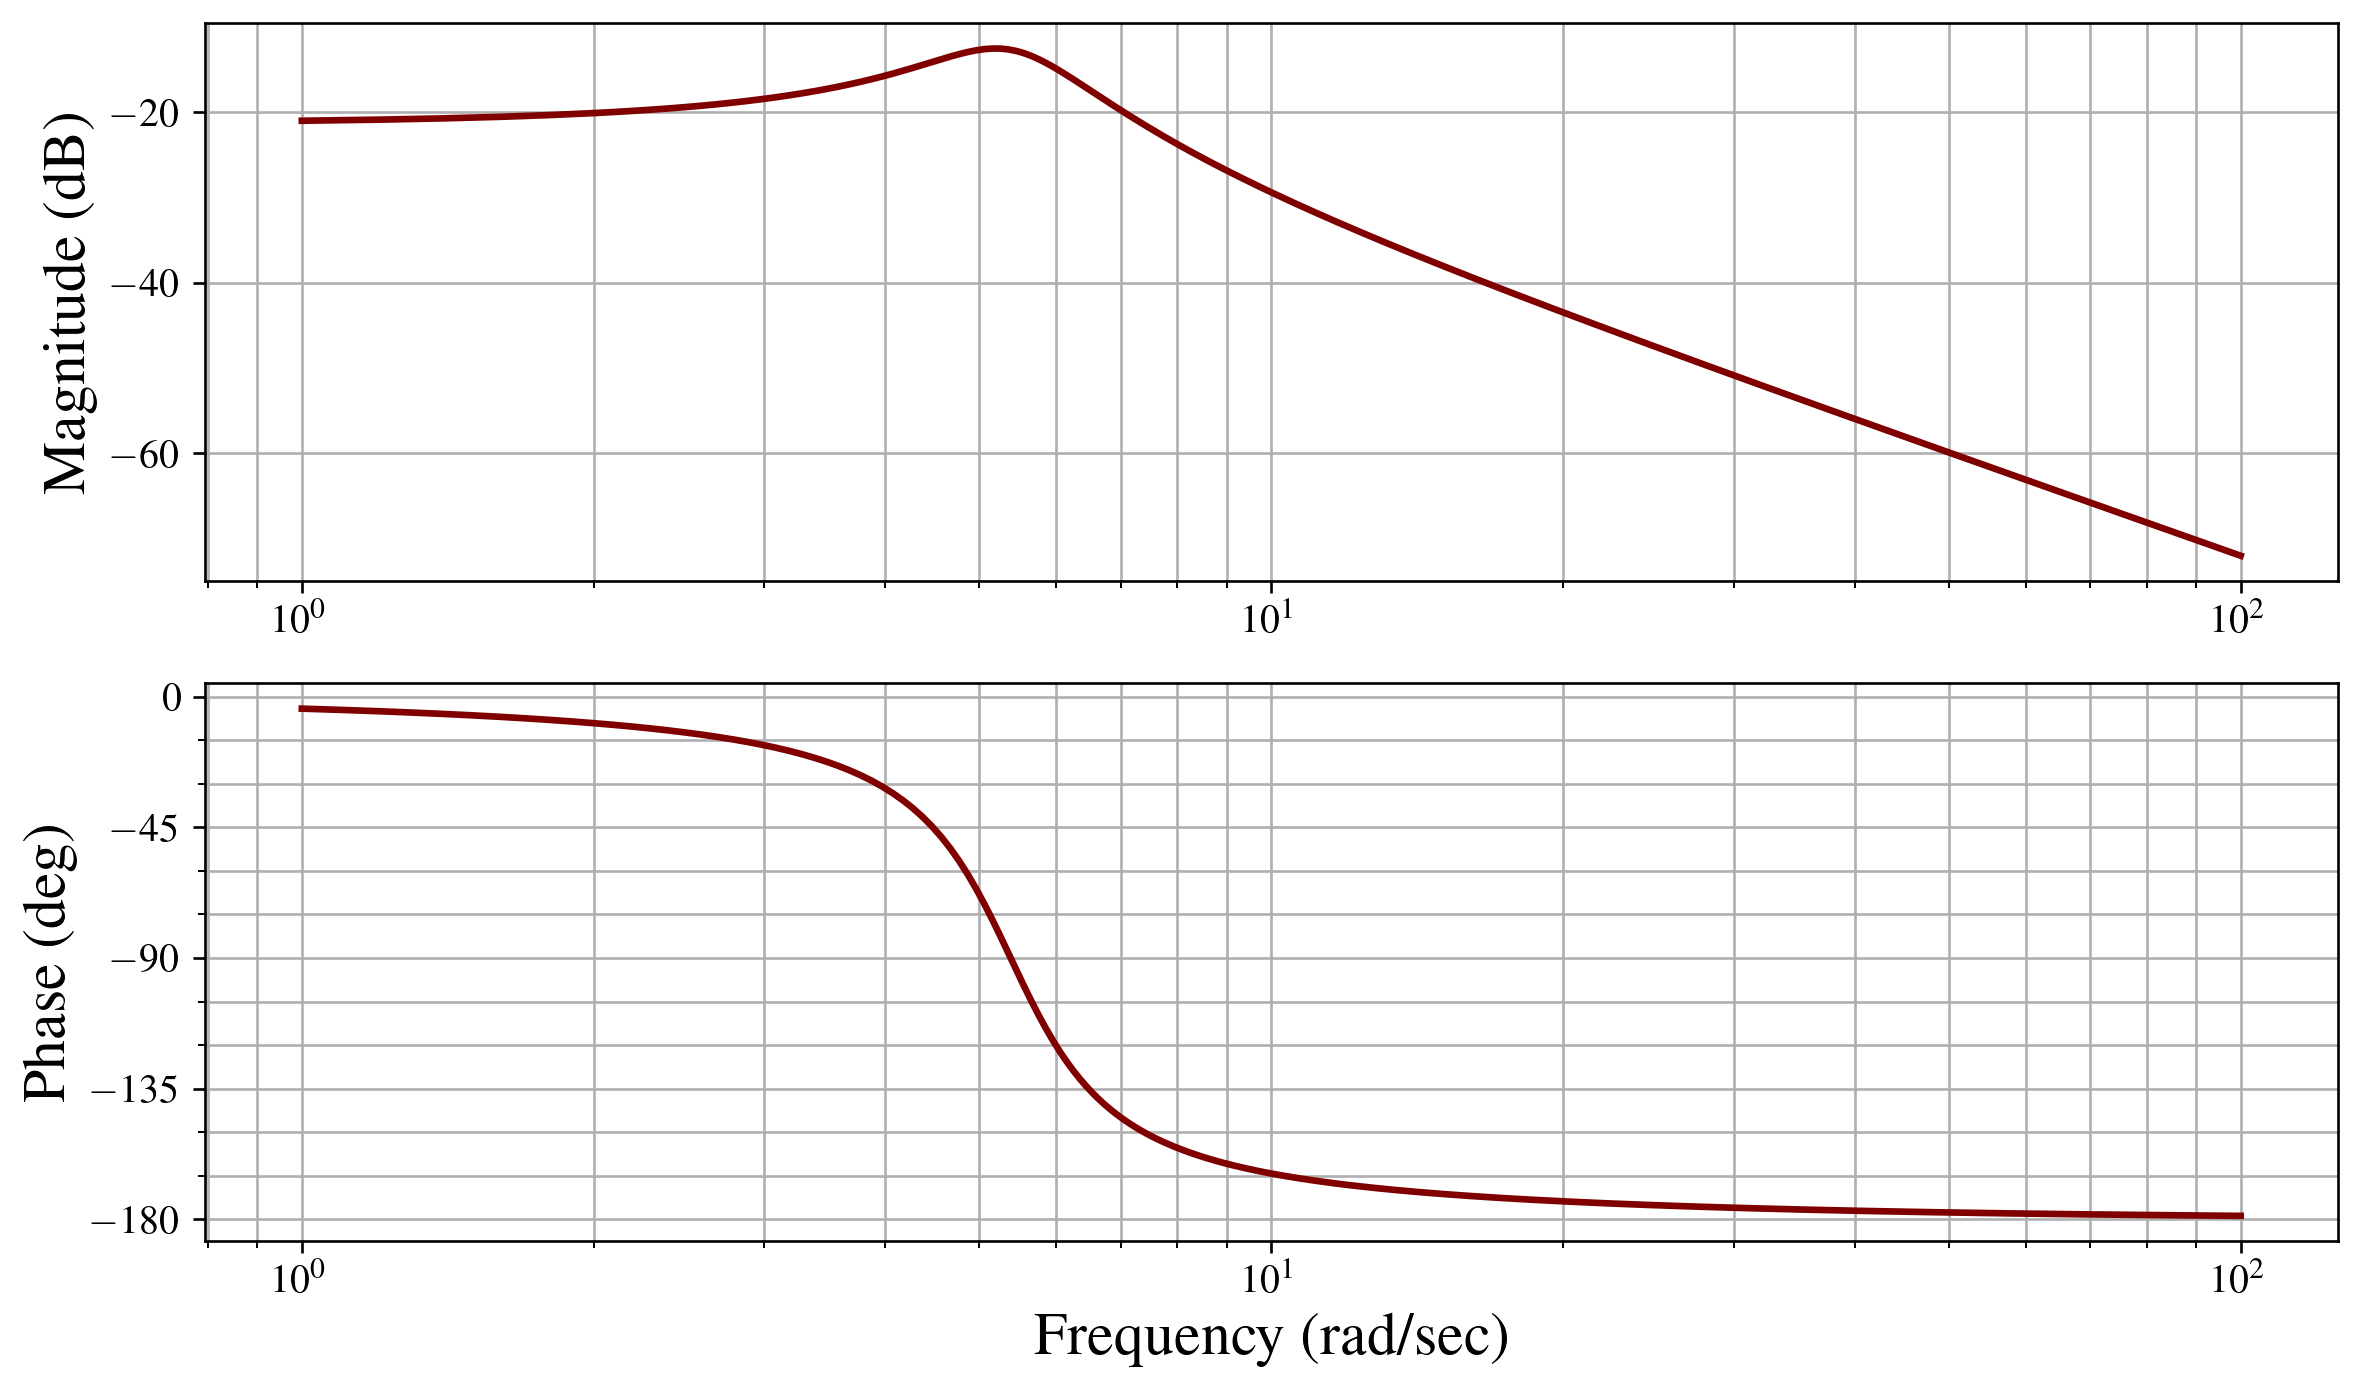

In [11]:
mag, phase, _ = ct.bode(T, omegas, plot=True, dB=True)

# Getting the Steady State
We are finding the steady state if the input function is $f(t)=5\sin(7t)$

In [12]:
T_7j = T_s.subs(s, 7*sp.I)
T_7j = np.complex64(T_7j)  # Converts to numpy world
T_7j

(-0.08389262-0.05872483j)

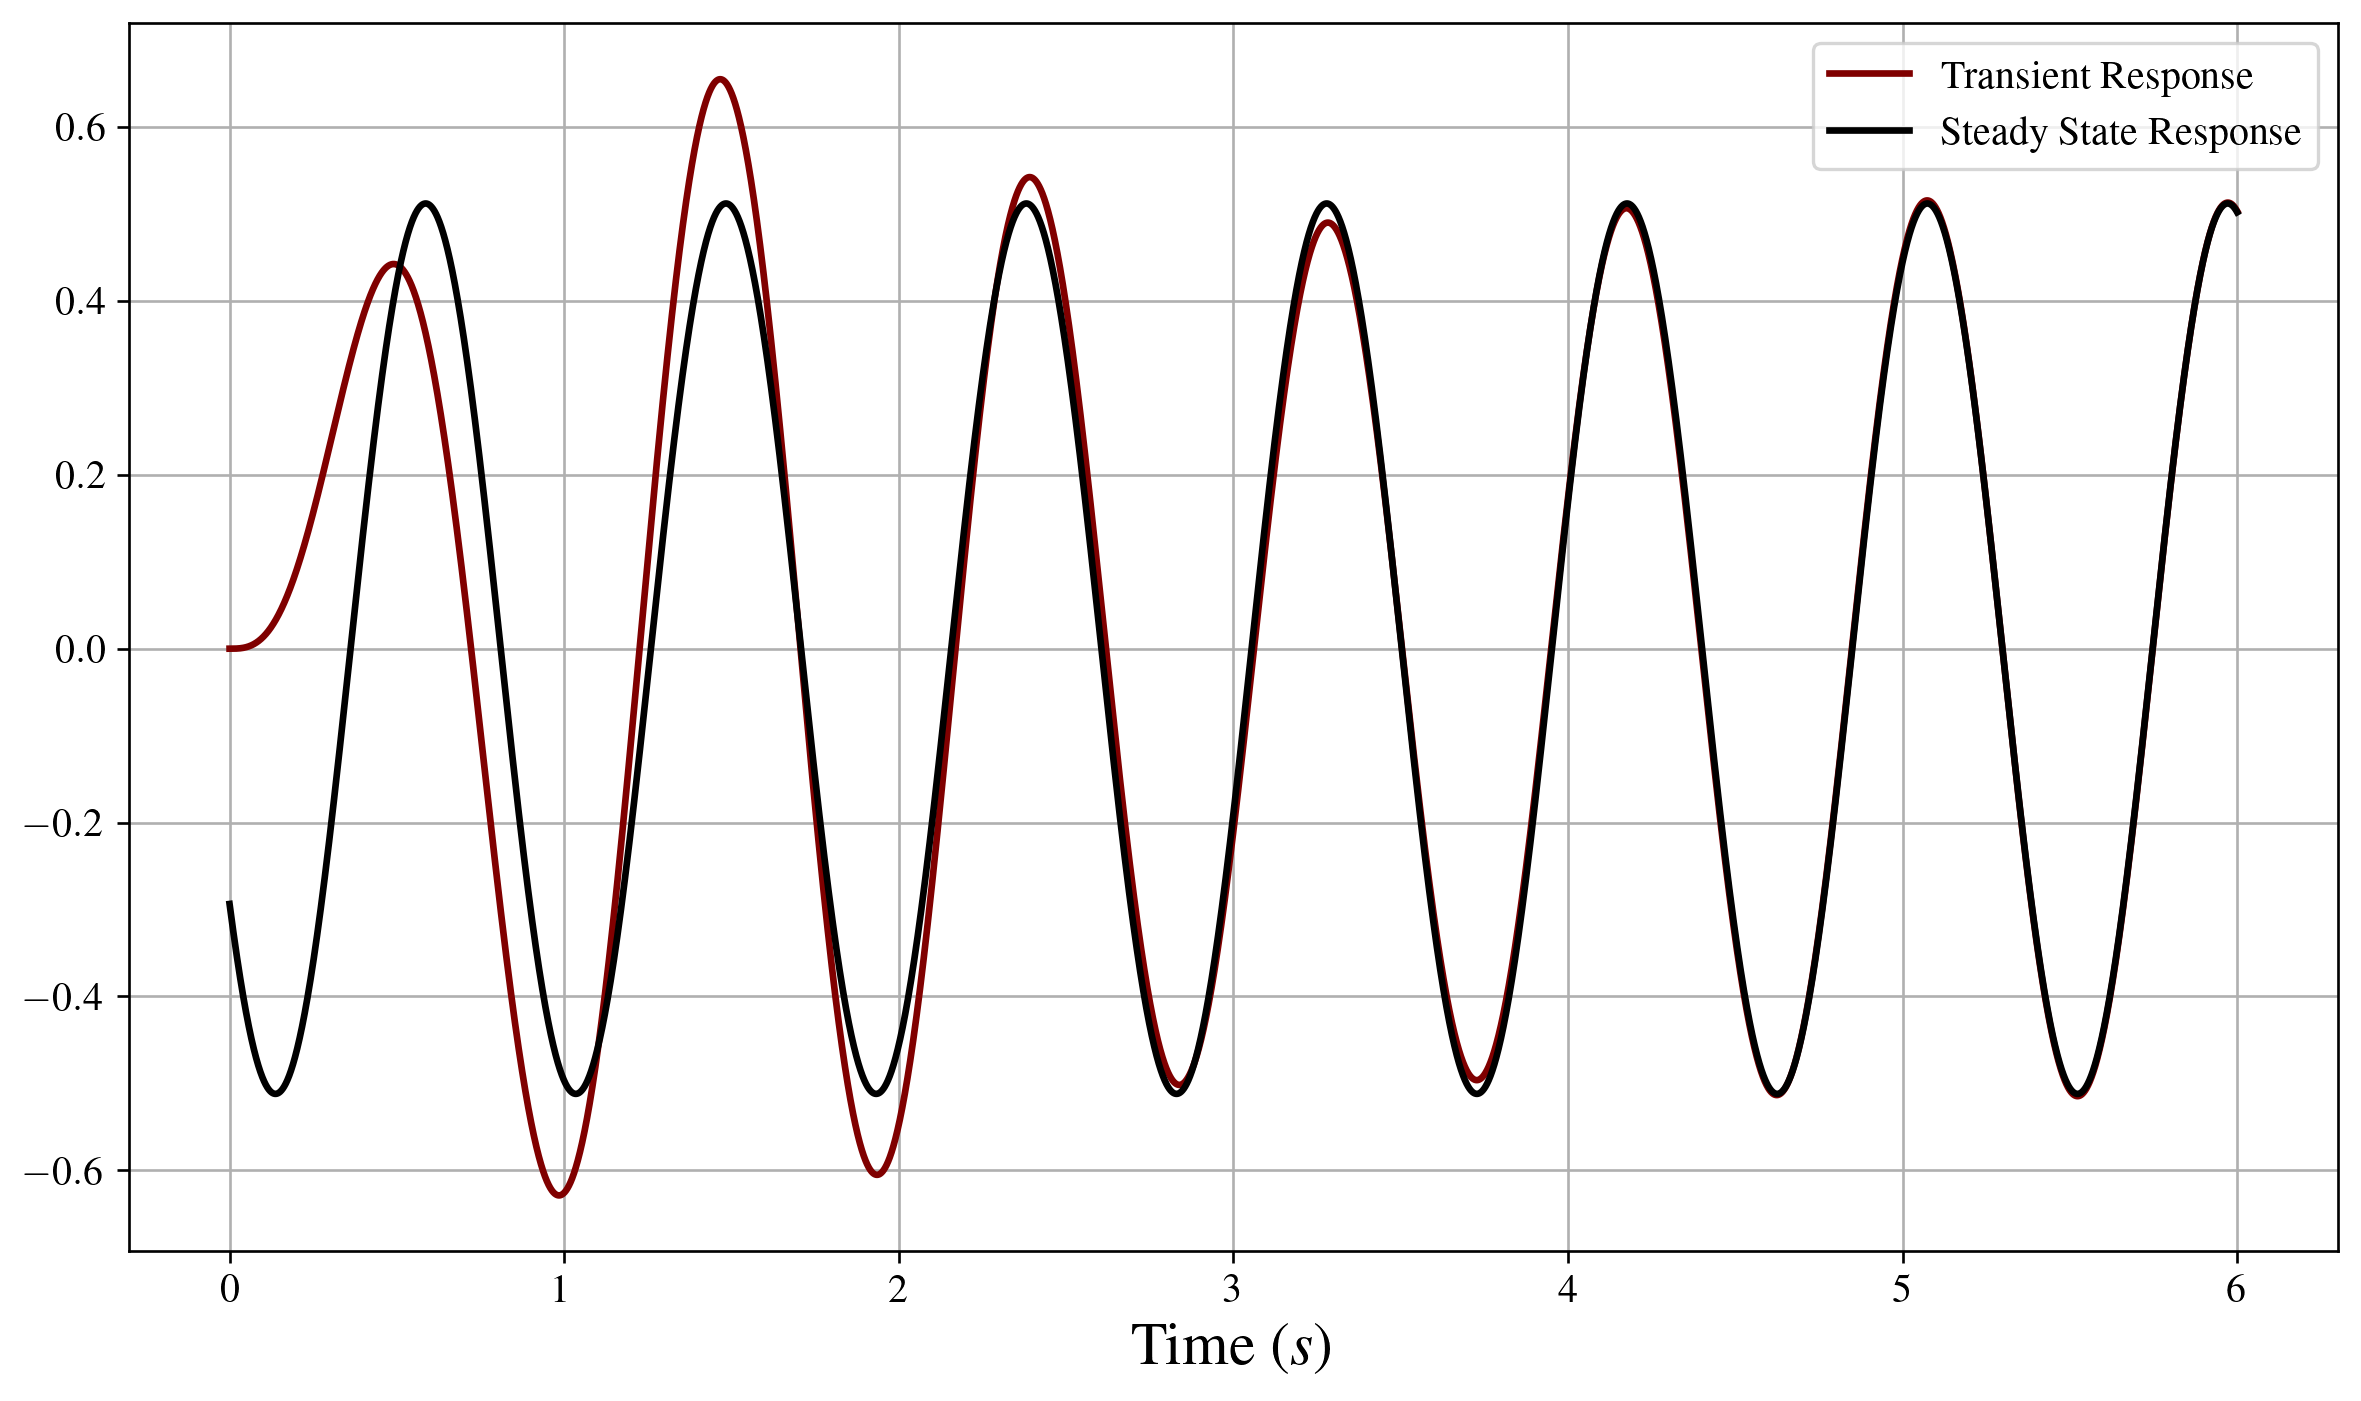

In [13]:
phi = np.angle(T_7j)
M = np.abs(T_7j)
B = 5*M
xss = lambda t_: B*np.sin(7*t_ + phi)

t_array = np.linspace(0, 6, 10_000)
_, response = ct.forced_response(T, T=t_array, U=5*np.sin(7*t_array))

plt.plot(t_array, response, label='Transient Response')
plt.plot(t_array, xss(t_array), label='Steady State Response')
plt.xlabel('Time ($s$)')
plt.legend()
plt.show()

# Comparing Various Input Frequencies

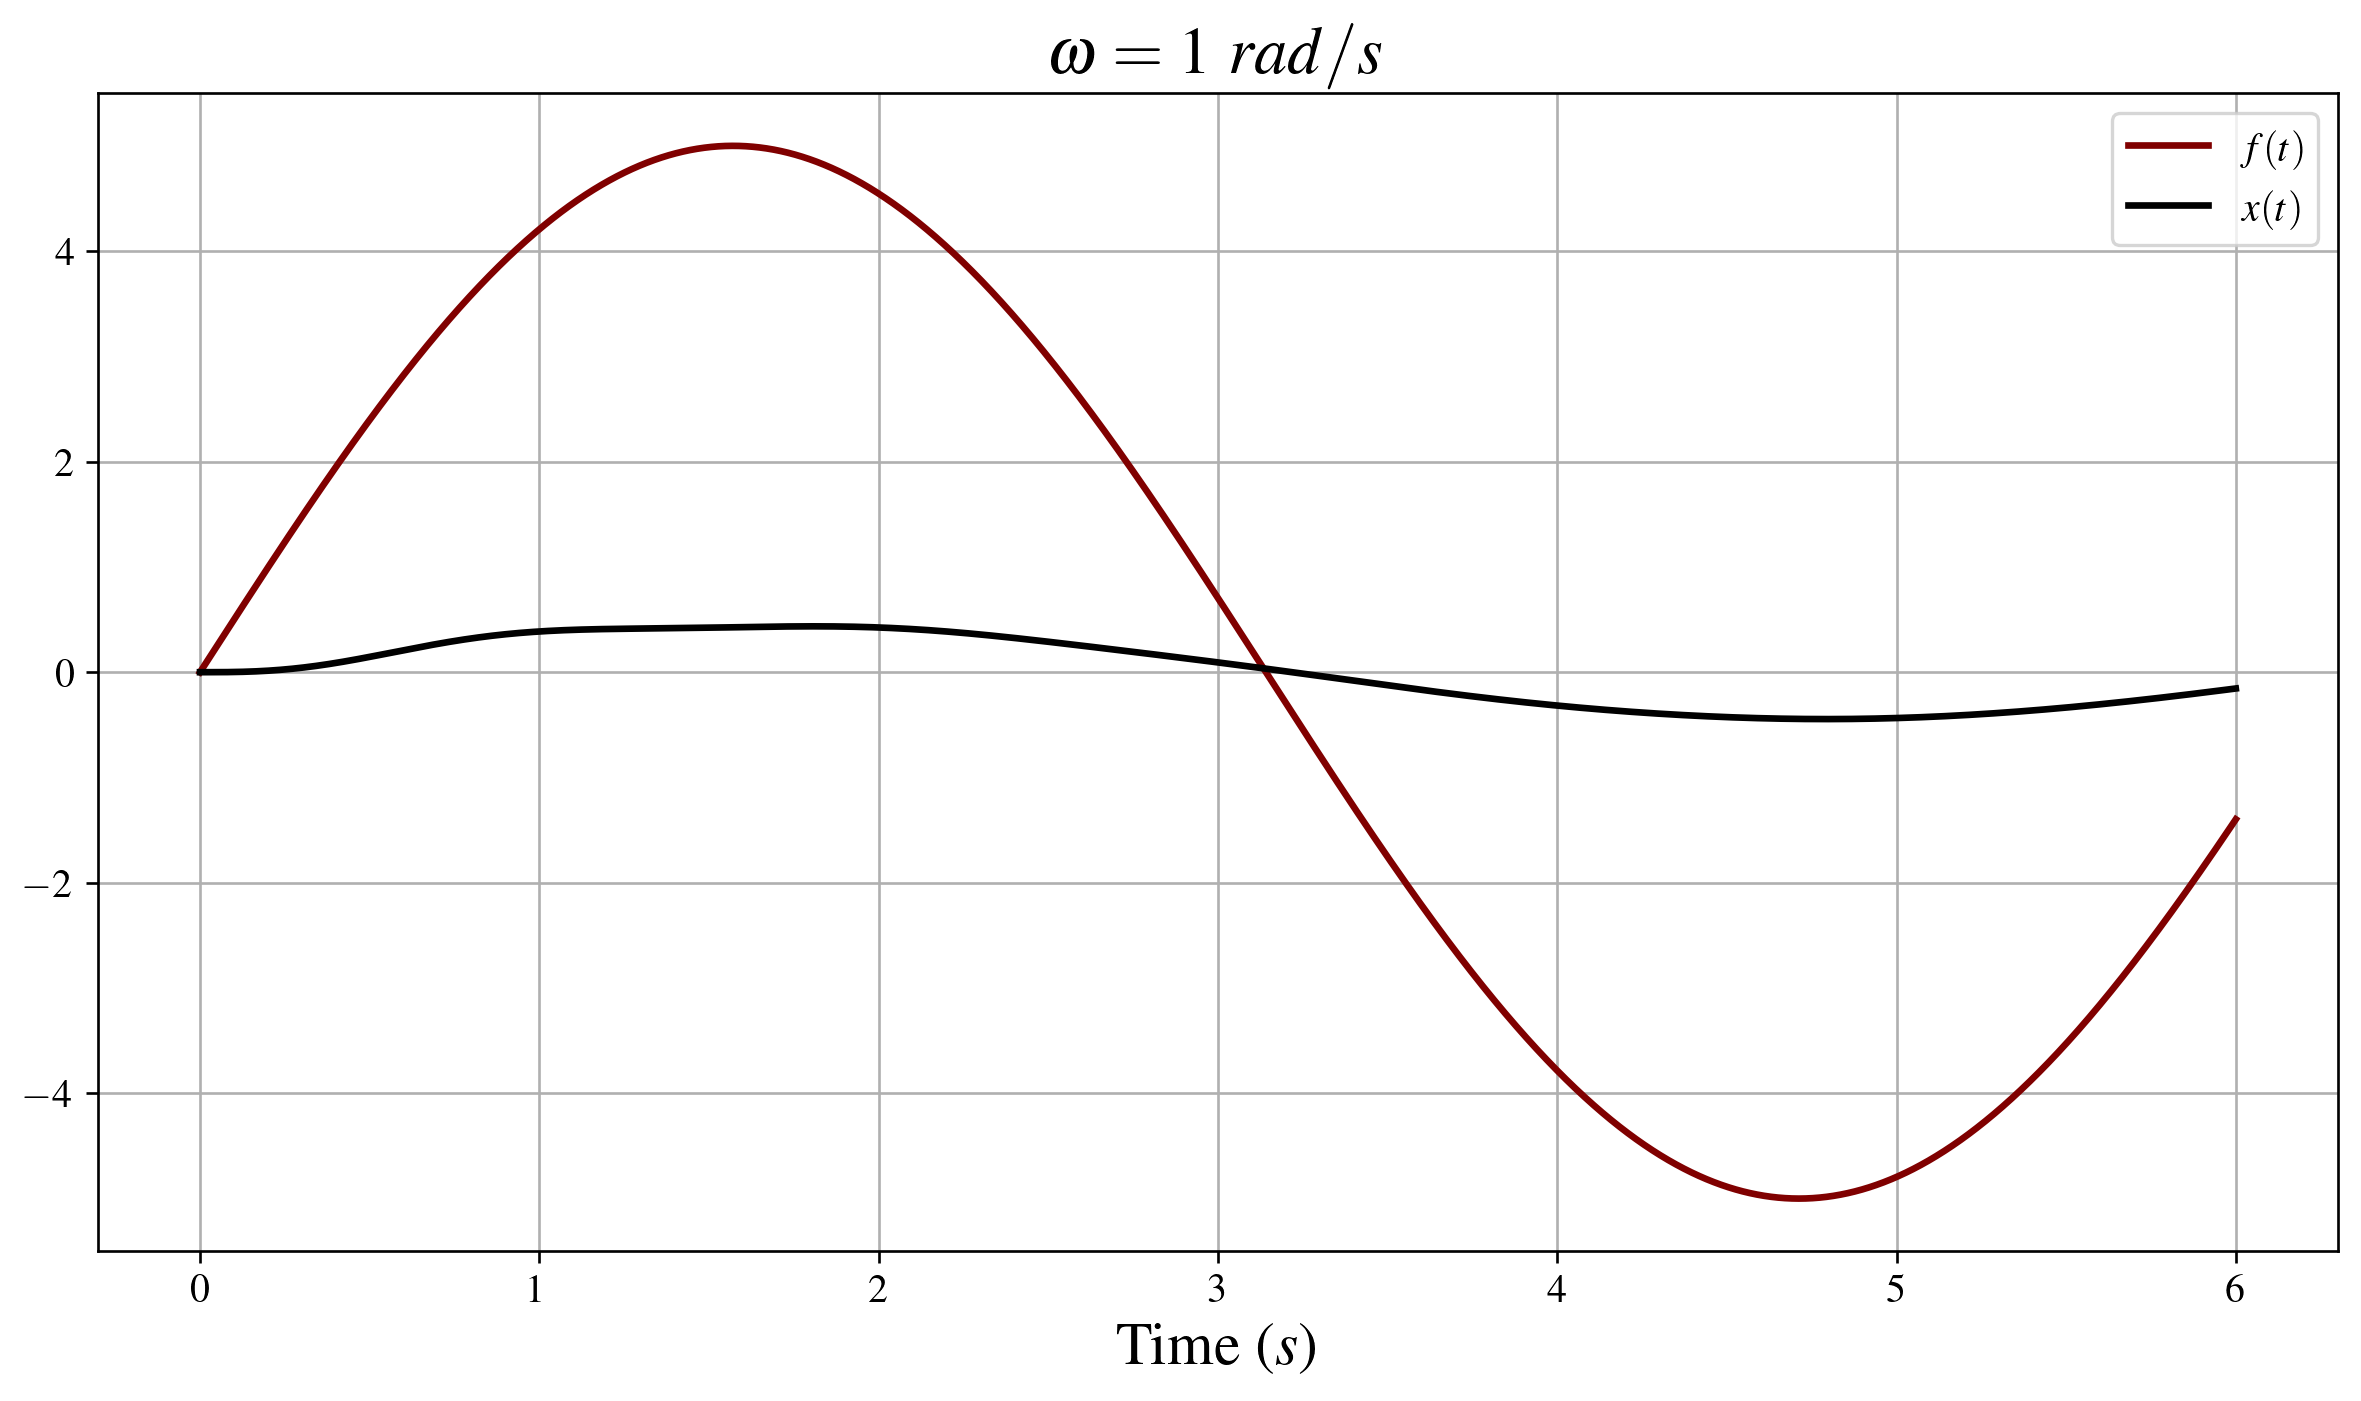

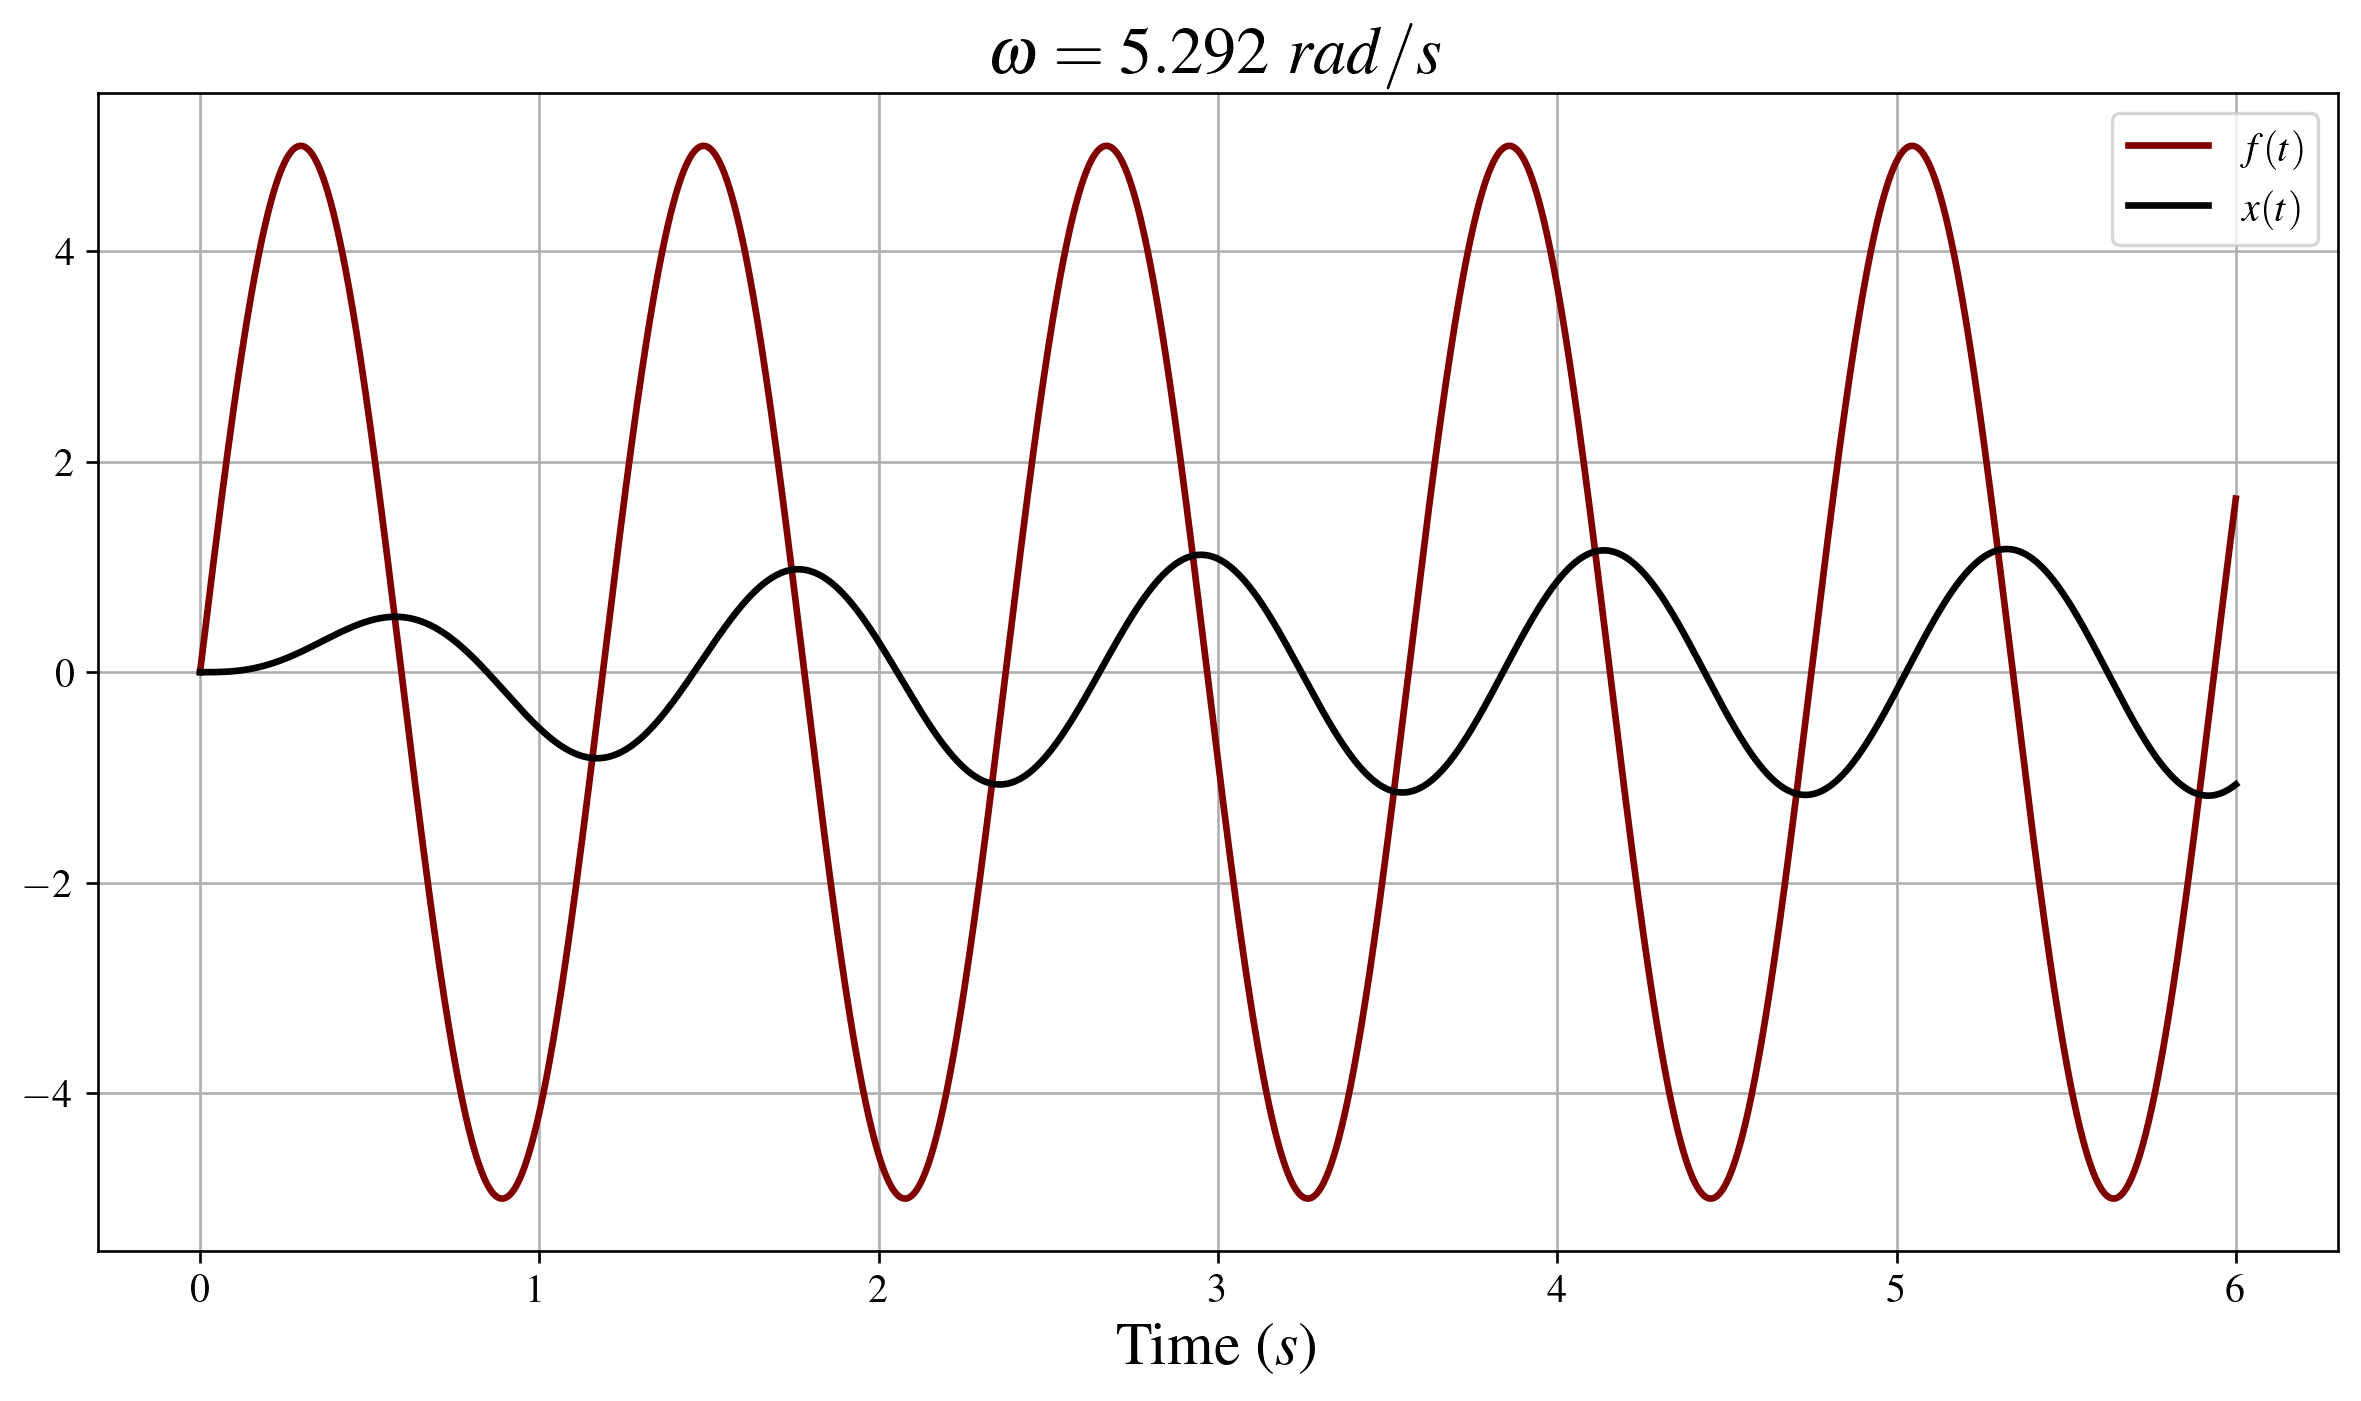

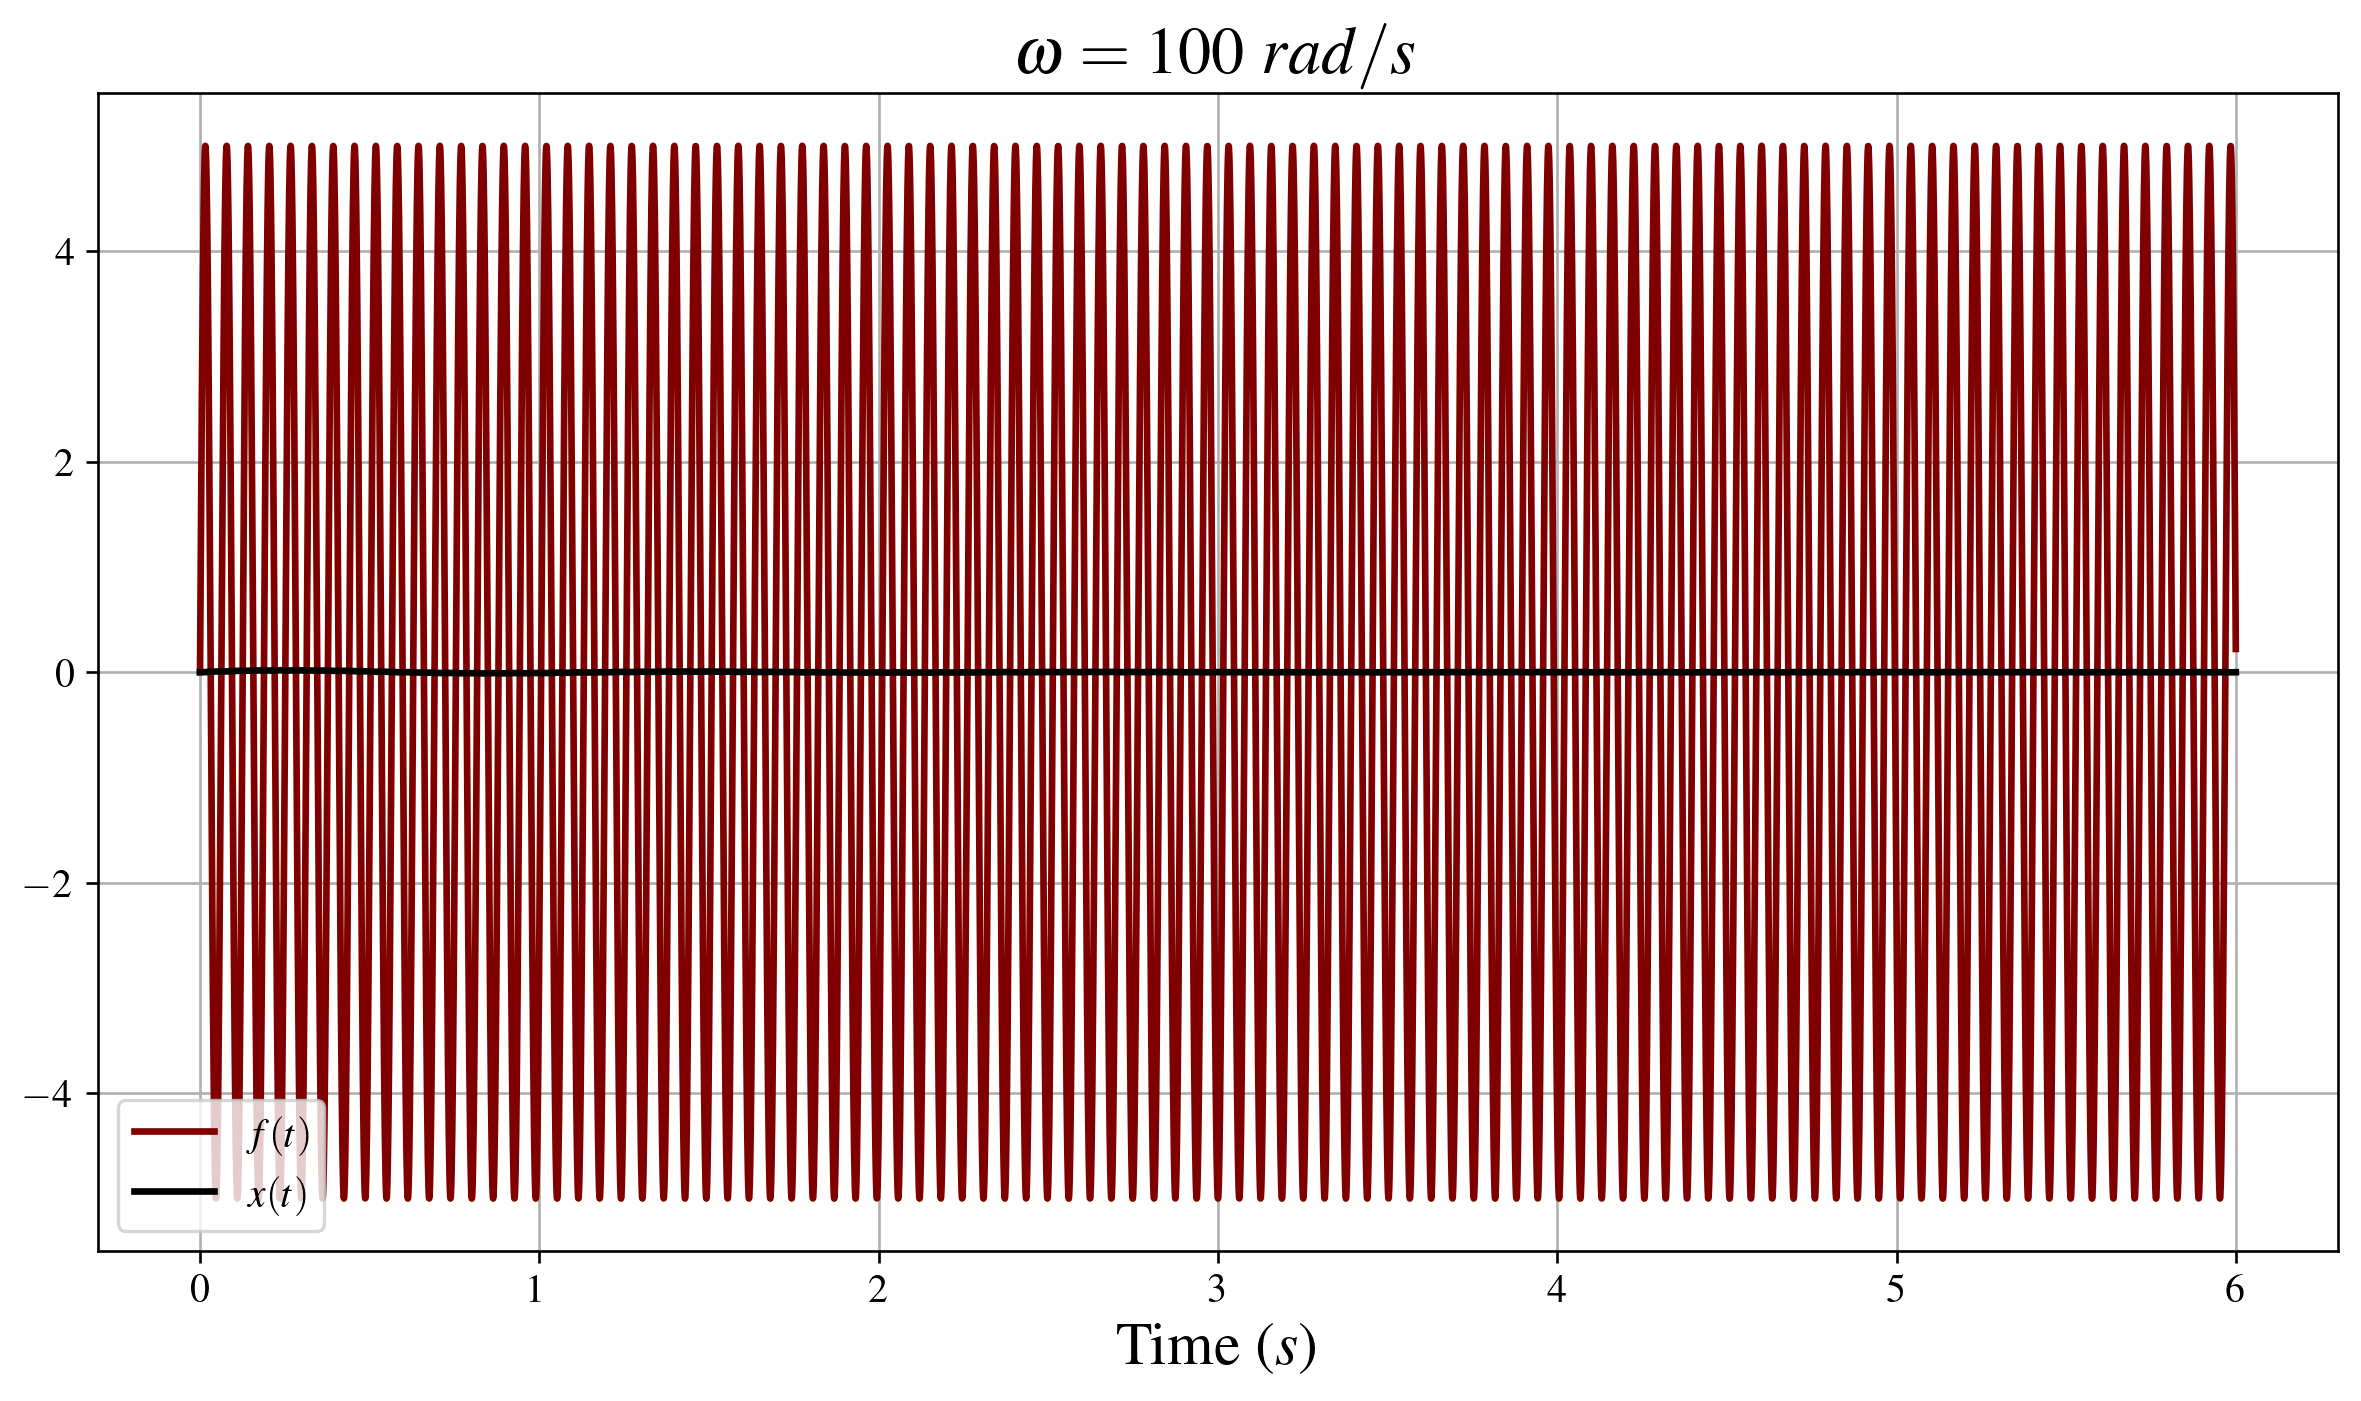

In [14]:
# Testing for omega = 1, 5.292, and 100 rad/s
oms = [1, 5.292, 100]

for omega in oms:
    f = lambda t_: 5*np.sin(omega*t_)
    _, response = ct.forced_response(T, T=t_array, U=f(t_array))
    
    fig, ax = plt.subplots()
    ax.plot(t_array, f(t_array), label='$f(t)$')
    ax.plot(t_array, response, label='$x(t)$')
    ax.set_title(rf'$\omega={omega}$ $rad/s$')
    ax.set_xlabel('Time ($s$)')
    ax.legend()
    
plt.show()

## Explanation
For $\omega=1\,rad/s$, we notice that the magnitude response is not negligible, and the phase is closely in line with the input. For $\omega=5.292\,rad/s$, we notice that the output is largely out of phase, and the magnitude is much larger than the previous value. This is because the input frequency is close to the natural frequency of the system. For $\omega=100\,rad/s$, we notice that there is almost no response because the magnitude response is lower.